<a href="https://colab.research.google.com/github/nightted/Travel-Recommend-project/blob/main/Googlemap_Store_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A project to recommend the hotels according to the surrounding stores and attractions

---
Outline :

1.  根據 All餐廳s + All 便利商店s "密度" (有人 Prefer "安靜" , 有人愛 "鬧區與便利"), 以及想吃&去的 target store 位置( EX: 牛肉湯,肉燥飯,觀光景點,網美餐廳...) & 密度來選擇住的區域 (還在發想要不要加入 ratings 來做選擇的 weighting)
2.  選擇區域後 , 再根據區域內 target store 分布 , 以及機能密度 , 以及"想去的景點"(演算法待想) , 來選擇區域內的一個 center 來當搜尋中心點. 
3.  根據中心點 , 抓初 circle 範圍內一定的推薦數量(User control)的 hotels , 並根據 user 所設的 criteria ( ratings , 民宿or飯店類型 ...) 來 filter hotels 
4. 從 booking 爬取及時房況 (直接一間一間 POST filter 出來的 hotels ?) 並呈現在頁面上.
https://colab.research.google.com/drive/1gpdM-l18V49edFp4I1_mR5p6ilcHRc2_
---

Hotel object construction 流程上的定義 :

-> 利用 Gmap API 建立 hotel 基本資訊 (name , location ,google_rating) 

-> 確認 hotel 房源 , **並交叉比對房源上的是不是真的存在此 hotel

-> 確認完後 , 建立 (room_source , source_name)

-> 利用目前 attribute:(name , location ,google_rating , room_source ,
  source_name) 來建立 store objects

** 交叉比對房源方法 :

-> extract addresses of hotels  

-> put addresses into booking search 

-> get href and get detail inner-page information

-> extract address from inner-page information

-> compare the addresses between gmaps and 
   
   booking , if extremly close (<50m) , 
   
   return True else False . 







#TODO LIST
1. #TODO(Done) : sightseeing spot and 網美景點
2. #TODO : 決定選區演算法 (Done , see current idea)
3. #TODO(Done by 11/13) : 把 store data class 化的必要? (精簡程式碼)
*  Current idea :

*   step.1 算出美食與便利店密度, 當作機能指標 (Done , 11/6 新增 rating_depent ,
      11/7 修改 grid_generator 新增 'normal' mode)
*   step.2 尋找機能密度 peak , 抓出前幾大 peak 的位置 (這邊如果有加入想去的景點選
      項, peak 選擇可加入此條件考量 , EX: 離景點最近的 peak) 
*   step.3 找到 peak 後 , 按 peak 所在的 grid 做上下左右的搜索 , 並設置 target 
      S =  機能密度 x 想吃的食物數目(要考慮評價 ,利用 radius search)  

4. #TODO : 飯店附近推薦美食 , 需用 googlesearch package 來抓google搜尋blog結果 

5. #TODO : add adddress into  class attribute




In [1]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.2-cp36-none-any.whl size=37858 sha256=db8515bbfca8410c56a3ab0b4177a96922a185270af35943edded6906f1ee3ba
  Stored in directory: /root/.cache/pip/wheels/f4/21/41/0c84572e21d52bb322f6c299f38ac7cd8ad6d4d6ce23dc3631
Successfully built googlemaps


In [59]:
import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.cluster import KMeans
import time 
import os 
import seaborn as sns
import math 
from functools import partial , reduce  
import requests
from bs4 import BeautifulSoup


def save_pkl(path  , data):
    with open(path , "wb") as pkl :
        pickle.dump(data , pkl)
        
def load_pkl(path):
    with open(path , "rb") as pkl :
        data = pickle.load(pkl) 
    return data
    
key_path = '/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/API_KEY/API_KEY.txt'
storage_path = '/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan'
name_transform = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Hotel_name_transform.pickel')
lng_1 = 102.516520*1000 # 1 longitude to meters
lat_1 = 110.740000*1000 # 1 latitude to meters

Admin_area_range_lng = [120.035794 , 120.656100]
Admin_area_range_lat = [22.888356 , 23.412317]

In [15]:
# Loading data 
grid_to_latlng = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Gird_to_latlng/grid_to_latlng')

data_all_objects = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/data_all_objects') # note that : need class definition to read pickle => https://stackoverflow.com/questions/47713175/attributeerror-while-unpickling-cant-get-attribute-location

data_train_station = load_pkl(os.path.join(storage_path ,'data_train_station'))
#data_hotel = grab_nearby_point( '飯店' , location , radius = 200 ) #飯店 store
data_hotel = load_pkl(os.path.join(storage_path ,'data_hotel'))
#data_rest = grab_nearby_point('餐廳', location , 400) #餐廳 store
data_rest = load_pkl(os.path.join(storage_path ,'data_rest'))
#data_beefsoup = grab_nearby_point('牛肉湯', location , 1000) #牛肉湯 store
data_beefsoup = load_pkl(os.path.join(storage_path ,'data_beefsoup'))
#data_porkrice = grab_nearby_point('肉燥飯', location , 1000) # 肉燥飯 store
data_porkrice = load_pkl(os.path.join(storage_path ,'data_porkrice'))
#data_EelNoodles = grab_nearby_point('鱔魚意麵', location , 1000 , ranging = 2) # 鱔魚意麵 store 
data_EelNoodles = load_pkl(os.path.join(storage_path ,'data_EelNoodles'))
#data_gruel = grab_nearby_point('鹹粥', location , 1000 , ranging = 2) # 鹹粥 store 
data_gruel = load_pkl(os.path.join(storage_path ,'data_gruel'))
#data_nightmarket = grab_nearby_point('夜市', location , 1000) # 夜市 store
data_nightmarket = load_pkl(os.path.join(storage_path ,'data_nightmarket'))
#data_con = grab_nearby_point('便利商店', location , 1000) # 便利商店 store
data_con = load_pkl(os.path.join(storage_path ,'data_con'))
data_sightseeing = load_pkl(os.path.join(storage_path ,'data_sightseeing'))

In [ ]:
# Saving Data
#save_pkl(os.path.join(storage_path ,'data_all_objects') , data_all_objects)
#save_pkl(os.path.join(storage_path ,'data_train_station') , data_train_station)
#save_pkl(os.path.join(storage_path ,'data_rest') , data_rest)
#save_pkl(os.path.join(storage_path ,'data_beefsoup') , data_beefsoup) 
#save_pkl(os.path.join(storage_path ,'data_nightmarket') , data_nightmarket)
#save_pkl(os.path.join(storage_path ,'data_porkrice') , data_porkrice)
#save_pkl(os.path.join(storage_path ,'data_con') , data_con)
#save_pkl(os.path.join(storage_path ,'data_hotel') , data_hotel)
#save_pkl(os.path.join(storage_path ,'data_sightseeing') , data_sightseeing)
#save_pkl(os.path.join(storage_path ,'data_gruel') , data_gruel)
#save_pkl(os.path.join(storage_path ,'data_EelNoodles') , data_EelNoodles)

In [102]:
# read API_KEY 
def read_key(key_path):
  with open(key_path , 'r') as f:
    KEY = f.read()
  return KEY

# find if english word in string 
def find_english_char(string):
  for chr in string:
    if chr.encode('UTF-8').isalpha():
      return True
  return False

# get the all continus digits in string
def get_digits(text):
  dummy = ''
  collect = []
  for idx ,chr in enumerate(text):
    if chr.isdigit():
      dummy += chr
    if not chr.isdigit() or idx == len(text)-1:
      if len(dummy) > 0:
        collect.append(dummy) 
        dummy = ''
      else:
        continue

  return collect

# Check the place is in target admin_area or not
def check_place_in_range(lnglat , Admin_area_range_lng , Admin_area_range_lat):
  
  return Admin_area_range_lng[0]<lnglat['lng']<Admin_area_range_lng[1] and Admin_area_range_lat[0]<lnglat['lat']<Admin_area_range_lat[1]
                  
# generate grid of position by radius
def grid_generator( location , radius , ranging , mode = "max_area"):
    
    '''
    # function : generate search points (grid)

    location : search center (grid start generating from this point) 

    radius : interval between grid point

    ranging : number of search points to generate in top,bottom,left,right ( 1 ranging equal to generate 2 points about 1 radius interval in "full-cover" mode)


    @ is scan point in grid

    mode 'normal : @--2*r--@--2*r--@--2*r--@--2*r--@ 
             @--2*r--@--2*r--@--2*r--@--2*r--@

    mode 'max_area' :    @--2*r--@--2*r--@--2*r-- 
                --2*r--@--2*r--@--2*r--@

    mode 'full_cover' :  @-r-@-r-@-r-@-r-@ 
                @-r-@-r-@-r-@-r-@ 

    '''

    rg = [ i for i in range(ranging,-(ranging+1),-1) ] #　get list between [int , -int]
    grid_delta_lng = radius / lng_1 # unit transform between meter and lat,lng  ( 1000m radius <=> 0.01 lag ,lng )
    grid_delta_lat = radius / lat_1

    lng , lat = location['lng'] , location['lat']
    # get the grids 
    grid_outer = [ {'lng': lng + grid_delta_lng *2* lng_delta , 'lat': lat + grid_delta_lat *2* lat_delta } for lng_delta in rg for lat_delta in rg ]

    if mode == 'max_area':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      
      return grid_outer + grid_inner

    if mode == 'full_cover':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_down = [ {'lng': dicts['lng']  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_aside = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat']  } for dicts in grid_outer ] 

      return grid_outer + grid_inner + grid_down + grid_aside

    return grid_outer 

def extract_address_by_geocode(maps , store_name):
  
  try :
    address , lnglat = geocode_subprocess(maps , store_name)
    if check_place_in_range(lnglat , Admin_area_range_lng , Admin_area_range_lat):
      return address
    else:
      print('[WARNING] This place is not in Taiwan!') 

  except IndexError:
    print(f'[WARNING] No such hotel found in geocode : {store_name}!')
     
  return None 

def geocode_subprocess(maps , store_name):
  
  # administrative level : 
  # postal_code(區碼) > country(國) > administrative_area_level_1(市) > administrative_area_level_2 > administrative_area_level_3(區) > route(路街巷) > street_number(號) > subpremise(樓)
  administrative_level = {
    "postal_code_suffix" : 10,
    "postal_code" : 9,
    "country" : 8,
    "administrative_area_level_1" : 7 ,
    "administrative_area_level_2" : 6 ,
    "administrative_area_level_3" : 5 ,
    "locality" : 4,
    "route" : 3 ,
    "street_number" : 2 ,
    "subpremise" : 1
  }

  geo_res = maps.geocode( store_name , language='zh-TW' ) 
  address = [ level_ad['long_name'] for level_ad in sorted( geo_res[0]['address_components'] 
                                   ,reverse=True 
                                   ,key=lambda x: administrative_level[x['types'][0]]) 
                                    if not find_english_char(level_ad['long_name'])  ] # get address by administrative level 
  address = ''.join(address) # combine address by administrative level
  address = address + get_digits(geo_res[0]['formatted_address'])[0] + '號' if '號' not in address else address # if not contain '號' ,get No. in formatted_address 
  address = address[3:] # remove 7XX postal code
  
  lnglat = geo_res[0]['geometry']['location']

  return address , lnglat


# get store information with location , keyword , search radius  
def store_scraper( maps,
          keyword , 
          location , 
          location_admin , 
          radius , 
          next_page_token , 
          objects , 
          store_type = None ):

    '''
    # function : get stores with keyword in some radius

    keyword : keyword of store you want to search 

    location : search center 

    radius : search radius

    next_page_token : to get data of page 20~40 , 40~60  

    objects : objects already storage (list)

    '''

    if objects == None:      
        objects = []

    res = maps.places_nearby( page_token = next_page_token , keyword = keyword , location = location , radius = radius , language = 'zh-TW')   #get stores list nearby   
    for store_inform in res['results']:

        lat_lng = store_inform['geometry']['location']
        lat , lng = lat_lng['lat'] , lat_lng["lng"]
        store_name = store_inform['name']
        rating = store_inform.get('rating',None)
 
        # exclude stores not contains ratings
        if rating:
          
            try:
            # In this part , there's 2 kind of ERROR here
            # 1. The address we got contains English words (We need chinese!!!)
            # 2. Can't get the address directly from store_inform dictionary (KeyError)
            # when encounters this 2 condition , use the geocode() to get address again. 
              address = store_inform['plus_code']['compound_code'].split(' ')[-1] + store_inform['vicinity']
              if find_english_char(address):
                # In this part , there's also 2 kind of WARNINGs here
                # 1. The geocode returned isn't in locality
                # 2. The geocode can't find any result
                # when encounters this 2 condition , use the original address we got. 
                print(f'[ENGLISH ERROR] {store_name} change to geocode !')
                extract_address = extract_address_by_geocode(maps , store_name) 
                address = extract_address if extract_address != None else address

            # if key error when finding address , special handling 
            except KeyError:
              print(f'[KEYERROR ERROR] {store_name} change to geocode !')
              extract_address = extract_address_by_geocode(maps , store_name) 
              address = extract_address if extract_address != None else address

            address = address.split('號')[0] + '號' # remove following char after '號' and 70X at head , EX : 700中西區海安路256號一樓 => 中西區海安路256號
            print(f' 地址:{address} , 店名:{store_name}' )

            information = {'location' : [lng , lat] , 
                      'store_name' : store_name , 
                      'rating' : rating ,
                      'admin_area' : location_admin ,
                      'address' : address
                    } 
                      
            store_obj = Store(store_type , information) if store_type != 'hotel' else Hotel(store_type , information)

            if store_obj not in objects : # discard None-rating store and add new items if it's not already exsit
              objects.append(store_obj)

        else :
          print(f"[WARNING] {store_name} doesn't contains rating !")
        
        
    next_page_token = res.get( 'next_page_token' , None ) # get if token exsit or return None 

    return next_page_token  , objects

# get store information with location , keyword , search radius (plus the change pages and move search location)
# 1 ranging is across 2 * radius in each sides  
# EX : radius = 1000 , ranging = 1 , so the spanning region is 2000 in top,bottom,left,right directions , total scan area = 4000 X 4000 .
def moving_store_scraper( maps,
              keyword , 
              search_center , 
              admin_area , 
              radius , 
              ranging , 
              next_page_token = None , 
              objects = None , 
              store_type = None ,
              mode = "max_area" ):

    '''
    # function : get stores with keyword in range of grid

    keyword : keyword of store you want to search 

    location : search center 

    radius : search radius

    next_page_token : to get data of page 20~40 , 40~60  

    objects : objects already storage (list) 
    '''
    
    search_points = grid_generator(search_center , radius , ranging , mode = mode)
    for idx , location in enumerate(search_points): 

        print(f'finish [{idx+1}/{len(search_points)}] parts !')       
        while True : # change page
            next_page_token ,  objects = store_scraper(  maps , 
                                      keyword , 
                                      location , 
                                      admin_area , 
                                      radius , 
                                      next_page_token = next_page_token , 
                                      objects = objects , 
                                      store_type = store_type)
            if next_page_token == None :
                break
            time.sleep(3) #set time sleep to avoid request too often !
    return objects

def update_new_stores( keyword , 
            search_center , 
            admin_area , 
            radius , 
            ranging , 
            store_type ):


    '''
    # function : update new store data

    store_type : ['data_rest', 'data_train_station', 'data_hotel', 'data_beefsoup', 'data_porkrice', 'data_EelNoodles', 'data_gruel', 'data_nightmarket', 'data_con', 'data_sightseeing']

    '''

    store_type = f'data_{store_type}'
    object_list = data_all_objects[store_type]
    modified_list = moving_store_scraper( keyword , search_center , admin_area , radius , ranging , store_type = store_type , objects = modify_list )

    return modified_list


# store weighting
def rating_modify(rating):
    
    if  4.8 < rating <= 5.0 :
        score = 512.0
    elif 4.6 < rating <= 4.8 :
        score = 256.0
    elif 4.4 < rating <= 4.6 :
        score = 128.0
    elif 4.2 < rating <= 4.4 :
        score = 64.0
    elif 4.0 < rating <= 4.2 :
        score = 32.0
    elif 3.8 < rating <= 4.0 :
        score = 16.0
    elif 3.6 < rating <= 3.8 :
        score = 8.0
    elif 3.4 < rating <= 3.6 :
        score = 4.0
    elif 3.2 < rating <= 3.4 :
        score = 2.0
    else:
        score = 1.0
    
    return score

def distance(a , b):

    '''
    get distnace of two point (in unit of meter)
    '''
    a_x , a_y = a[0] , a[1]
    b_x , b_y = b[0] , b[1]
    delta_x_meter = (a_x-b_x)*lng_1
    delta_y_meter = (a_y-b_y)*lat_1

    return ((delta_x_meter)**2 + (delta_y_meter)**2 )**0.5

# grab the store contain some keyword (ex: 扁食)
def grab_keyword_store( data , keyword = ''):

  '''
  # function : transform data to numpy

  data : list of store objects

  keyword : to filter keyword in store_name

  '''
 
  x ,y , x_y , rat , name = [] , [] , [] , [] , []
  for item in data:
    if keyword in item.name : # if keyword == None , grab all stores
      x.append(item.location[0])
      y.append(item.location[1])
      x_y.append(item.location)
      #rat.append(rating_modify(item['rating'])) # rating func 要修正XD , EX: 4.8~5.0 => 10 分 , 4.6~4.8 => 9 分 , ... , < 3.0 => 1分
      rat.append(item.rating)
      name.append(item.name)

  return x , y , x_y , rat ,name

In [19]:
GOOGLE_API_KEY = read_key(key_path)
maps = googlemaps.Client(key = GOOGLE_API_KEY)

In [47]:
position = "春川煎餅"
result = maps.geocode(position , language='zh-TW' )

In [48]:
location = result[0]['geometry']['location']
location

{'lat': 22.9913113, 'lng': 120.198012}

In [92]:
# TEST for geocode 
posi = "XING HWA MAO BUSINESS HOTEL"
resu = maps.geocode(posi , language='zh-TW' )
resu

[{'address_components': [{'long_name': 'Tainan',
    'short_name': 'Tainan',
    'types': ['administrative_area_level_3', 'political']},
   {'long_name': '台南市',
    'short_name': '台南市',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '台灣', 'short_name': 'TW', 'types': ['country', 'political']},
   {'long_name': '700', 'short_name': '700', 'types': ['postal_code']}],
  'formatted_address': 'No.115, Sec. 1, Yongfu Road, Tainan, 台南市台灣 700',
  'geometry': {'location': {'lat': 22.9843942, 'lng': 120.2000551},
   'location_type': 'GEOMETRIC_CENTER',
   'viewport': {'northeast': {'lat': 22.98574318029151,
     'lng': 120.2014040802915},
    'southwest': {'lat': 22.9830452197085, 'lng': 120.1987061197085}}},
  'place_id': 'ChIJwTQYxn52bjQR4lJXBR4jDMI',
  'plus_code': {'compound_code': 'X6M2+Q2 台灣台南市中西區',
   'global_code': '7QJ2X6M2+Q2'},
  'types': ['establishment', 'lodging', 'point_of_interest']}]

In [105]:
dummy_hotel = moving_store_scraper( maps , keyword = '飯店' , search_center = location , admin_area = 'Tainan' , radius = 500 , ranging = 0 , store_type = 'hotel'  )

finish [1/2] parts !
 地址:台灣台南市中西區永福路一段269號 , 店名:Lakeshore Hotel Tainan
 地址:台灣台南市中西區友愛街115巷5號 , 店名:U.I.J Hotel & Hostel - 友愛街旅館
 地址:台灣台南市中西區西門路一段658之2號 , 店名:和逸飯店‧台南西門館 HOTEL COZZI Ximen Tainan
 地址:台灣台南市中西區西門路二段23號 , 店名:Hotel A．台南 ( 聖禾大飯店 )-商務洽公旅宿 親子家庭住宿(推薦人氣必住)
 地址:台灣台南市中西區永福路一段269號 , 店名:煙波大飯店台南館
 地址:台灣台南市中西區民生路二段76號 , 店名:台南富驛時尚酒店
 地址:台灣台南市中西區忠義路二段28號 , 店名:富華大飯店
 地址:台灣台南市中西區和意路1號 , 店名:台南晶英酒店 Silks Place Tainan
 地址:台灣台南市中西區康樂街156號 , 店名:Unique Hotel-達煦23旅店
 地址:台灣台南市中西區永福路二段150之1號 , 店名:台南名世大飯店
 地址:台灣台南市中西區正興街198號 , 店名:好趣旅店 How Chill Inn｜風格設計｜台南住宿｜旅客五星好評一致推薦
 地址:台灣台南市中西區康樂街169號 , 店名:道達旅店 D.D Hotel
 地址:台灣台南市中西區友愛街148號 , 店名:古根文旅(緩慢文旅)
 地址:台灣台南市中西區尊王路126號 , 店名:日升大飯店
 地址:台灣台南市中西區尊王路158號 , 店名:捷喬商務旅館
 地址:台灣台南市中西區金華路三段218號 , 店名:星鑽國際商旅
 地址:台灣台南市中西區西門路一段703巷10號 , 店名:玩家小西門
 地址:台灣台南市中西區中正路349號 , 店名:啤酒花大酒店
 地址:台灣台南市中西區尊王路79號 , 店名:RGB府城留宿(RGB Stay Life)
 地址:台灣台南市中西區大智街63-2號 , 店名:府城旅行家民宿Taiwan Multi-Fun（貿庭旅宿）
 地址:台灣台南市中西區西門路二段76號 , 店名:台南-立多文旅
 地址:台灣台南市中西區中正路90號 , 店名:泊樂行旅-中正館(Hotel Brown - Zhongzheng bran

In [32]:
add = []
for hotel in dummy_hotel:
  add.append([hotel.__dict__['name'],hotel.__dict__['address']])
add

[['Lakeshore Hotel Tainan', '南市中西區永福路一段269號'],
 ['U.I.J Hotel & Hostel - 友愛街旅館', '南市中西區友愛街115巷5號'],
 ['和逸飯店‧台南西門館 HOTEL COZZI Ximen Tainan', '南市中西區西門路一段658之2號'],
 ['Hotel A．台南 ( 聖禾大飯店 )-商務洽公旅宿 親子家庭住宿(推薦人氣必住)', '南市中西區西門路二段23號'],
 ['煙波大飯店台南館', '南市中西區永福路一段269號'],
 ['台南富驛時尚酒店', '南市中西區民生路二段76號'],
 ['富華大飯店', '南市中西區忠義路二段28號'],
 ['台南晶英酒店 Silks Place Tainan', '南市中西區和意路1號'],
 ['Unique Hotel-達煦23旅店', '南市中西區康樂街156號'],
 ['台南名世大飯店', '南市中西區永福路二段150之1號'],
 ['好趣旅店 How Chill Inn｜風格設計｜台南住宿｜旅客五星好評一致推薦', '南市中西區正興街198號'],
 ['道達旅店 D.D Hotel', '南市中西區康樂街169號'],
 ['古根文旅(緩慢文旅)', '南市中西區友愛街148號'],
 ['日升大飯店', '南市中西區尊王路126號'],
 ['捷喬商務旅館', '南市中西區尊王路158號'],
 ['星鑽國際商旅', '南市中西區金華路三段218號'],
 ['啤酒花大酒店', '南市中西區中正路349號'],
 ['玩家小西門', '南市中西區西門路一段703巷10號'],
 ['RGB府城留宿(RGB Stay Life)', '南市中西區尊王路79號'],
 ['府城旅行家民宿Taiwan Multi-Fun（貿庭旅宿）', '南市中西區大智街63-2號'],
 ['台南-立多文旅', '南市中西區西門路二段76號'],
 ['泊樂行旅-中正館(Hotel Brown - Zhongzheng branch)', '南市中西區中正路90號'],
 ['【La Locanda】天井 · 樹 Atreeium', '南市中西區國華街三段9巷11號'],
 ['RAITO Hostel 來多旅宿', '南市中西區府

In [ ]:
# compare name between gmaps and booking 
for idx , hotel in enumerate(dummy_hotel):
  
  if idx > 1 :
    break
  
  address_gmaps = hotel.address
  inform_dic = get_hotel_information(address_gmaps) 
  href = inform_dic['href']
  new_url = header_url + href
  detail_inform_soup = send_request( new_url ,method = "GET" )

  address_booking = detail_inform_soup.find( 'span' , {'class' : "hp_address_subtitle js-hp_address_subtitle jq_tooltip" })
  result_booking = maps.geocode( address_booking , language='zh-TW' )
  lat_lng_booking = result_booking[0]['geometry']['location']
  lat_lng_booking = [lat_lng_booking['lng'] , lat_lng_booking['lat']]

  # if distance of position in gmaps and booking almost the same , 
  # update the hotel attributes
  delta_distance = distance(hotel.location , lat_lng_booking)
  if delta_distance < 50 :
    hotel.room_source = 'booking'
    hotel.source_name = inform_dic['source_name']

  # <span> "class" : "hp_address_subtitle js-hp_address_subtitle jq_tooltip" </span>


串流輸出內容已截斷至最後 5000 行。
餐廳 &amp; 咖啡店
</span>
</div>
<ul class="bui-list bui-list--divided bui-list--text">
<li class="bui-list__item">
<div class="bui-list__body">
<div class="bui-list__description">
<span class="hp_location_block__section_list_key_tag">
咖啡店／酒吧
</span>
Starbucks 星巴克（永福門市）
</div>
<div class="bui-list__item-action hp_location_block__section_list_distance">
0.5 km
</div>
</div>
</li>
</ul>
</div>
<div class="hp_location_block__section_container">
<div class="bui-title bui-title--heading bui-spacer--large">
<span class="bui-title__text">
<svg aria-hidden="true" class="bk-icon -streamline-attractions location_section_icon" focusable="false" height="20" role="presentation" viewbox="0 0 24 24" width="20"><path d="M13.5 3a1.5 1.5 0 1 1-3 0 1.5 1.5 0 0 1 3 0zM15 3a3 3 0 1 0-6 0 3 3 0 0 0 6 0zm6 4.5a1.5 1.5 0 1 1-3 0 1.5 1.5 0 0 1 3 0zm1.5 0a3 3 0 1 0-6 0 3 3 0 0 0 6 0zM6 7.5a1.5 1.5 0 1 1-3 0 1.5 1.5 0 0 1 3 0zm1.5 0a3 3 0 1 0-6 0 3 3 0 0 0 6 0zM21 15a1.5 1.5 0 1 1-3 0 1.5 1.5 0 0

In [ ]:
for obj_h in dummy_hotel:
  if obj_h.room_source == 'booking':
    print(obj_h)
    obj_h.construct_attr_by_request(date = ['2020-12-10','2020-12-11'] , instant = True)
  else:
    continue

煙波大飯店台南館 is at [120.2000787, 22.9892135] and rating 4.4 in googlemap 
Silks Place Tainan is at [120.1993661, 22.9875244] and rating 4.5 in googlemap 
Hotel A．台南 ( 聖禾大飯店 )-商務洽公旅宿 親子家庭住宿(推薦人氣必住) is at [120.1975453, 22.9908946] and rating 4.4 in googlemap 
U.I.J Hotel & Hostel - 友愛街旅館 is at [120.1998688, 22.9909036] and rating 4.6 in googlemap 
HOTEL COZZI Tainan Ximen is at [120.198365, 22.987345] and rating 4.6 in googlemap 
Ying Dai Hotel is at [120.2059546, 22.9979129] and rating 4.3 in googlemap 
FX Hotel Tainan is at [120.1971189, 22.9953027] and rating 4 in googlemap 
樹舍TreeHouse-開山館 is at [120.2066063, 22.9896918] and rating 5 in googlemap 
Kindness Hotel - Chihkan Tower is at [120.2044777, 22.9944913] and rating 4.5 in googlemap 
La Plaza Hotel is at [120.203585, 22.999042] and rating 4 in googlemap 
富華大飯店 (Fuward Hotel) is at [120.2029449, 22.9916363] and rating 4.2 in googlemap 
Tainan Fushin Hotel is at [120.2009101, 23.0000386] and rating 4.3 in googlemap 
莯疇園雅築 is at [120.20

In [ ]:
for o in dummy_hotel:
  if o.room_source == 'booking': 
    if o.room_remainings == '太夯了!!已售完!!':
      print(o , '=>' , o.room_recommend , '=>' ,  o.room_remainings)

樹舍TreeHouse-開山館 is at [120.2066063, 22.9896918] and rating 5 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!
靡生 - Maison Bohe'me is at [120.2057852, 22.9927303] and rating 4.7 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!
宿影 Shadow house is at [120.204611, 22.994872] and rating 5 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!
Hotel de L'eau is at [120.185021, 22.995388] and rating 4.5 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!
首學大飯店 (Tainan First Hotel) is at [120.1950656, 22.9948072] and rating 3.5 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!
日艾 - SHiNE A1 is at [120.1939926, 22.9904434] and rating 4.1 in googlemap  => 太夯了!!已售完!! => 太夯了!!已售完!!


In [ ]:
x_rs , y_rs , x_y_rs , rating_rs , name_rs = grab_keyword_store(data_rest) # All 餐廳s
x_tr , y_tr , x_y_tr , rating_tr , name_tr = grab_keyword_store(data_train_station)             # train station 
x_bf , y_bf , x_y_bf , rating_bf , name_bf = grab_keyword_store(data_beefsoup , "牛肉湯")         # 牛肉湯
x_nm , y_nm , x_y_nm , rating_nm , name_nm = grab_keyword_store(data_nightmarket , 'Night Market')    # 夜市
x_pr , y_pr , x_y_pr , rating_pr , name_pr = grab_keyword_store(data_porkrice , '肉燥飯')         # 肉燥飯
x_cn , y_cn , x_y_cn , rating_cn , name_cn = grab_keyword_store(data_con)                  # 便利超商
x_h , y_h , x_y_h , rating_h , name_h = grab_keyword_store(data_hotel)                    # 飯店 
x_sight , y_sight , x_y_sight , rating_sight , name_sight = grab_keyword_store(data_sightseeing)       # 觀光景點
x_Eel , y_Eel , x_y_Eel , rating_Eel , name_Eel = grab_keyword_store(data_EelNoodles)            # 鱔魚意麵
x_gru , y_gru , x_y_gru , rating_gru , name_gru = grab_keyword_store(data_gruel)               # 鹹粥

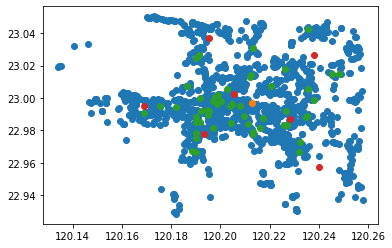

In [ ]:
plt.scatter(np.array(x_y_rs)[:,0],np.array(x_y_rs)[:,1])    # 餐廳
#plt.scatter(np.array([location['lng']]) , np.array([location['lat']])  ) # 台南火車站
#plt.scatter(np.array(x_y_bf)[:,0],np.array(x_y_bf)[:,1]) # 牛肉湯
#plt.scatter(np.array(x_y_nm)[:,0],np.array(x_y_nm)[:,1]) # 夜市
#plt.scatter(np.array(x_y_pr)[:,0],np.array(x_y_pr)[:,1]) # 肉燥飯
#plt.scatter(np.array(x_y_cn)[:,0],np.array(x_y_cn)[:,1]) # 便利商店
plt.scatter(np.array(x_y_tr)[:,0],np.array(x_y_tr)[:,1]) # train station
plt.scatter(np.array(x_y_Eel)[:,0],np.array(x_y_Eel)[:,1]) # Hotel
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])

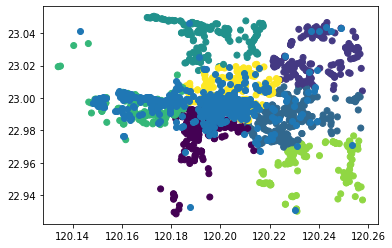

In [ ]:
# plot the KM of daily demands store and calculate each cluster center 
kmeans = KMeans(n_clusters=7).fit(x_y_rs)
plt.scatter(np.array(x_y_rs)[:,0],np.array(x_y_rs)[:,1], c=kmeans.labels_)
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.scatter(np.array(x_y_h)[:,0],np.array(x_y_h)[:,1])

#plt.scatter(np.array(x_y_cn)[:,0],np.array(x_y_cn)[:,1])
#plt.scatter(np.array(x_y_nm)[:,0],np.array(x_y_nm)[:,1])

# Grouping the stores


In [ ]:
[ [f'Group: {idx} ,', center ]  for idx , center in enumerate(kmeans.cluster_centers_)]

[['Group: 0 ,', array([120.19347102,  22.97808337])],
 ['Group: 1 ,', array([120.23780087,  23.02699732])],
 ['Group: 2 ,', array([120.22860748,  22.98752553])],
 ['Group: 3 ,', array([120.19532757,  23.03690482])],
 ['Group: 4 ,', array([120.1690571 ,  22.99526288])],
 ['Group: 5 ,', array([120.23990803,  22.95767118])],
 ['Group: 6 ,', array([120.20533248,  23.00215255])]]

In [ ]:
# grouping the x_y data by KM result to specified group 
def Grouping_data_by_zone(data , KM_label , group ): 

  return [ ele for idx , ele in enumerate(data) if KM_label[idx] == group ]
  
# grouping the target stores by KM result 
def Grouing_target_store_by_zone(x_y_target , KM_center):

  cluster_num = len(KM_center)
  group = np.zeros(len(x_y_target))

  for store_idx , position in enumerate(x_y_target):
    min = 1000000000
    for center_idx , cluster_center in enumerate(KM_center): 
      if distance(position , cluster_center) < min :
        min = distance(position , cluster_center)
        group_idx = center_idx

    group[store_idx] = group_idx
  return group

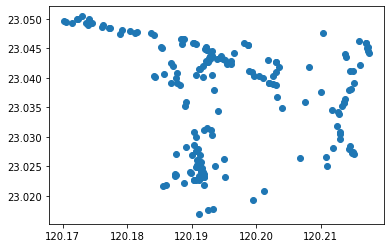

In [ ]:
data = x_y_rs
group_idx = 3

x_y_g = Grouping_data_by_zone(data , kmeans.labels_ , group_idx )
plt.scatter(np.array(x_y_g)[:,0],np.array(x_y_g)[:,1])

In [ ]:
target_store_label = Grouing_target_store_by_zone( x_y_rs , KM_center = kmeans.cluster_centers_ ) # get the grouping label of target store
store_rating_by_label = [ Grouping_data_by_zone( rating_rs , target_store_label , i ) for i in range(len(kmeans.cluster_centers_)) ] # by the grouping label , get the store ''information'' by zone
store_rating_by_label_ave = [ np.average(np.array(rating_score)) for rating_score in store_rating_by_label ] # rating ave. of every zone 
store_rating_by_label_ave

[4.306976744186047,
 4.229130434782609,
 4.3091205211726376,
 4.1866666666666665,
 4.2945,
 4.1988304093567255,
 4.301086956521739]

In [ ]:
# calculate the foucs_center where "best-food" is clutering at 
# TODO: need to modify due to new definition of target and surrounding stores
x_focus , y_focus = (x*rating).sum() / rating.sum() , (y*rating).sum() / rating.sum()
x_focus , y_focus

# Define store class 

In [13]:
# define an class-Store to encapsulate the creating function and attribute of stores
# initialize items => name , source_name(after name-matching) , location , google_rating
class Store(object):

  def __init__(self , store_type = None , dicts = None):

    self.store_type = store_type
    if dicts is not None:
      self.construct_attr_by_dict( dicts )
  
  def construct_attr_by_dict(self , store_dict):
    
    # basic attribute
    self.name = store_dict['store_name']
    self.location = store_dict['location']
    self.rating = store_dict['rating']
    self.admin_area = store_dict['admin_area']
    self.address = store_dict['address']

  def __repr__(self):
    return f'{self.store_type} : {self.name} is at {self.location} in {self.admin_area} and rating {self.rating} in googlemap '

  #https://stackoverflow.com/questions/6423814/is-there-a-way-to-check-if-two-object-contain-the-same-values-in-each-of-their-v
  def __eq__(self , other):
    return self.__dict__ == other.__dict__


class Hotel(Store):

  def __init__(self , store_type = 'hotel' , dicts = None):
    super().__init__( store_type , dicts )

  
  def compare_name_between_gmap_booking(self):

    '''
    # To construct source_name and room_source
    '''
    pass
  
  def construct_attr_by_dict(self , store_dict ):
    super().construct_attr_by_dict( store_dict )

    if 'room_source' in store_dict.keys():

      self.room_source = store_dict['room_source']
      self.source_name = store_dict['source_name']

      if self.room_source == 'booking':
        
        if 'href' in store_dict.keys(): # check one of the keys is in dict
          self.detail_href = store_dict['href']
          self.comment_num = store_dict['comment_num']
          self.star = store_dict['stars']
          self.pic_link = store_dict['pic_link']
          self.source_rating = store_dict['source_rating']

          self.pics = store_dict['pics']
          self.comments = store_dict['comments']
        else:
          print('[WARNING] Not contains more information !')

      elif self.room_source == 'agoda':
        pass
      else:
        pass
    
    else:
      pass

  def construct_attr_by_request(self , date = None , instant = False ):
    
    if self.source_name == None :

      print("[WARNING] No source_name and room_source , now scrape it !" )
      self.compare_name_between_gmap_booking() # compare and modify hotel name between gmap and booking

    # scraper for booking source
    if self.room_source == 'booking':

      if instant:     

        self.date = date # first day to check in
        if self.date != None:
          
          instant_dict = get_hotel_information( self.source_name , date = date ,  instant_information = True )

          self.room_recommend = instant_dict['room_recommend'] 
          self.room_remainings = instant_dict['room_remainings'] 
          self.hot = instant_dict['hot']
          self.price = instant_dict['price']
          self.instant_hrefs = instant_dict['instant_hrefs']

          # TODO : 這邊要給一個例外, 如果 room_recommend ,room_remainings 等等皆為已售完 , 則抓取前後兩天房源 ! (需有個地方儲存以便顯示)
          # => get_hotel_information( self.source_name , date = date +/- 1,2 ,  instant_information = True )

        else :
          print('[WARNING] No date assigned!')
      
      else:

        date = ['2020-12-16','2020-12-17'] #
        static_dict = get_hotel_information( self.source_name , date = date ,  instant_information = False )
        
        self.detail_href = static_dict['href']
        self.comment_num = static_dict['comment_num']
        self.star = static_dict['stars']
        self.pic_link = static_dict['pic_link']
        self.source_rating = static_dict['source_rating']
        
        static_dict_deatil = get_detail_hotel_information( self.detail_href )

        self.pics = static_dict_deatil['pics']
        self.comments = static_dict_deatil['comments']
    
    elif self.room_source == 'agoda:':
      pass
    else :
      pass

  def __repr__(self):
    return super().__repr__()

  def __eq__(self , other):
    return super().__eq__(other)

In [ ]:
# TODO : Transfer hotel data dicts into objects 
data_all_objects = {'data_resturant':data_rest,
      'data_train_station':data_train_station,
      'data_hotel':data_hotel,
      'data_beefsoup':data_beefsoup,
      'data_porkrice':data_porkrice,
      'data_EelNoodles':data_EelNoodles,
      'data_gruel':data_gruel,
      'data_nightmarket':data_nightmarket,
      'data_convenience':data_con,
      'data_sightseeing':data_sightseeing}

def transfer_to_object(data , data_name):

  store_type = data_name.split('_')[1]
  print(store_type)
  storage = []
  if store_type == 'hotel':
    for dic in data:
      obj = Hotel(store_type=store_type ,dicts=dic)
      storage.append(obj)

  else: 
    for dic in data:
      obj = Store(store_type=store_type ,dicts=dic) 
      storage.append(obj)

  return storage

for data_name , data in data_all_objects.items():

  dummy = transfer_to_object(data , data_name)
  data_all_objects[data_name] = dummy 

resturant
train
hotel
beefsoup
porkrice
EelNoodles
gruel
nightmarket
convenience
sightseeing


In [14]:
url = "https://www.booking.com/searchresults.zh-tw.html"
header_url = "https://www.booking.com"

def send_request( url , method = 'GET' , data = None , headers = None ):

  if method == "GET":
    res = requests.get(url , headers = headers)
  elif method == "POST":
    res = requests.post(url , data = data , headers = headers)
  else :
    print("[WARNING] No request method assigned!")

  res = res.content
  soup = BeautifulSoup(res , 'html.parser')

  return soup


#INPUT type scrape_time : ['2020-12-09' ,'2020-12-10']
def get_header_payload(scrape_time , target_hotel_or_address = None ):

  '''
  # function : get the headers and payload by scrape time

  target_hotel : if it's not assigned , scarpe all "台南" hotel 

  '''

  check_in_time = scrape_time[0].split('-')
  check_out_time = scrape_time[1].split('-')
  
  payload = {
    'checkin_year': check_in_time[0] ,
    'checkin_month': check_in_time[1] ,
    'checkin_monthday': check_in_time[2] ,
    'checkout_year': check_out_time[0] ,
    'checkout_month': check_out_time[1] ,
    'checkout_monthday': check_out_time[2] ,
    'aid': '1288258', # need or not?
    'label': 'label: metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0', # need or not?
    'sid': 'ab79516c4eea1e96b378b9c2338022ce', # need or not?
    'sb': '1', # need or not?
    'src': 'searchresults', 
    'src_elem': 'sb', # need or not?
    'ss': target_hotel_or_address if target_hotel_or_address else '台南', 
    'ssne': None if target_hotel_or_address else '台南', # place you want to search (encode)
    'ssne_untouched': None if target_hotel_or_address else '台南' , # place you want to search (encode)
    'is_ski_area': '0', # need or not?
    'dest_type': None if target_hotel_or_address else 'city', 
    'dest_id': None if target_hotel_or_address else '-2637868', # place id you want to search 
    'group_adults': '2', # number of people
    'group_children': '0', # number of children
    'no_rooms': '1', # number of rooms
    'from_sf': '1', # ???
    'ac_langcode': 'xt'

  }

  headers = {    
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36', # can be generate fake agent ??
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'error_url': "https://www.booking.com/index.zh-tw.html?aid=1288258;label=metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0;sid=ab79516c4eea1e96b378b9c2338022ce;sb_price_type=total;srpvid=f1b826d7eb680028&;",
    'content-security-policy-report-only': "report-uri https://csp-receiver.booking.com/csp_violation?type=report&tag=112&pid=040f2610ef80010a&e=UmFuZG9tSVYkc2RlIyh9YRdubXl3m7MIPItwv4TRRzARPrDvNuzlrbfIvmyYAyhkeKKOaHLiHXalz9oYwBjSNw&f=2&s=0; frame-ancestors 'none';",
    'Referer' : 'https://www.booking.com/index.zh-tw.html?aid=376396&label=booking-name-yefrPbbyS%2AFIINHgyCnmNgS267725091255%3Apl%3Ata%3Ap1%3Ap22%2C563%2C000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-65526620%3Alp1012818%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YfqnDqqG8nt1O4nYvDr1lms&sid=99dd5960476d5bf057cf94fe33e3deb6&srpvid=6d1e3723a19e0104&click_from_logo=1',
    'Host': 'www.booking.com',    
    'Upgrade-Insecure-Requests': '1',
    'Accept-Language': 'zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1' ,
    'Connection': 'keep-alive'
  }
  
  return payload , headers

# check target information in search result or not
def check_alive_or_not( search_result , text = True , tag  = None , msg_if_none = None ):
  '''
  text : if True , get text in tag ; if False , get tag property

  tag : if not none , get property of that tag
  '''
  if not search_result:
    return msg_if_none
  return search_result.text if text else search_result[tag]


# get information of hotels
def get_hotel_information( hotel_name_or_address , date = None ,  instant_information = False ):

  '''
  #function : get hotel information including non-instant or instant data by hotel_name

  hotel_name : enter name of hotel in "booking or agoda" website

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )

  date : day to check-in and check-out , ex: ['2020-12-10','2020-12-11']

  '''

  date = date if instant_information else ['2020-12-10','2020-12-11']

  payload , headers = get_header_payload( date , target_hotel_or_address = hotel_name_or_address )
  soup = send_request( url , method = 'POST' , data = payload , headers = headers)

  soup_content = soup.find_all( "div" , { 'class' : "sr_item_content sr_item_content_slider_wrapper "})[0]
  soup_pic = soup.find_all( "div" , { 'class' : "sr_item_photo sr_card_photo_wrapper"})[0]
    
  return extract_informations_from_soup( soup_content , soup_pic , instant_information )

# extract information from soup
def extract_informations_from_soup( soup_content , soup_pic , instant_information = False ):

  '''
  # function : extract information from soup

  soup_content , soup_pic : content of soup

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )
  '''

  # p class="simple_av_calendar_no_av sold_out_msg"
  if instant_information :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">

    room_soldout = bool(soup_content.find('p' , { 'class' : "simple_av_calendar_no_av sold_out_msg"}))
    if room_soldout:
      return {'room_recommend' : '太夯了!!已售完!!' ,
           'room_remainings' : '太夯了!!已售完!!' ,
           'hot' : '太夯了!!已售完!!' ,
           'price' : '太夯了!!已售完!!' ,
           'instant_hrefs' : '太夯了!!已售完!!' }

    hotel_room_recommend = soup_content.find('div', {'class':"room_link"}).find('strong').text # get the recommend romm type  (instant information)
    hotel_room_remainings = check_alive_or_not(soup_content.find('span', {'class':"only_x_left sr_rooms_left_wrap "}), msg_if_none = '房源還很充足!' ).rstrip("\n").strip("\n") # get remaining rooms (instant information)
    hotel_hot = check_alive_or_not(soup_content.find('div' , {'class' : 'rollover-s1 lastbooking'}) , msg_if_none = '快上網站訂房!').rstrip("\n").strip("\n") # get the hot of hotels (instant information) 不是每個hotel都有此block !!!!!
    hotel_price = soup_content.find('div' , {'class' : "bui-price-display__value prco-inline-block-maker-helper" }).text.rstrip("\n").strip("\n") # get hotels price (instant information)
    hotel_instant_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs

    # !!BUGS: price 部分有 /xa0124 encode 的問題
    return {'room_recommend' : hotel_room_recommend ,
          'room_remainings' : hotel_room_remainings ,
          'hot' : hotel_hot ,
          'price' : "".join(hotel_price.split()) , # remove /xa0 
          'instant_hrefs' : hotel_instant_hrefs }


  else :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">
    hotel_name = soup_content.find('span', {'class':"sr-hotel__name "}).string.rstrip("\n").strip("\n") # get hotels
    hotel_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs 
    # these items below may not exist
    hotel_rating = check_alive_or_not( soup_content.find( "div" , { 'class' : "bui-review-score__badge"}) )
    hotel_comment_num = check_alive_or_not( soup_content.find('div' , {"class" : "bui-review-score__text"}) ) # get # of comments 
    hotel_star = check_alive_or_not( soup_content.find('span' , {'class' : "bui-rating bui-rating--smaller" }) , text = False , tag = 'aria-label') # get star of hotel 

    ### get below <div class="sr_item_photo sr_card_photo_wrapper" id="hotel_5621655">
    hotel_pic_link = soup_pic.find('img' , {'class' : "hotel_image" })['data-highres'] # get hotel review pic

    return {'source_name' : hotel_name ,
        "href": hotel_hrefs , 
        "comment_num": hotel_comment_num ,
        "stars": hotel_star ,
        "pic_link": hotel_pic_link ,
        "source_rating": hotel_rating }


def get_detail_hotel_information( hotel_href ):

  '''
  # function : get detail hotel information by inner pages

  hotel_href : the url to inner pages
  
  '''
  new_path = header_url + hotel_href
  soup = send_request(new_path)

  soup_sub = soup.find('div' , { 'class' : " clearfix bh-photo-grid fix-score-hover-opacity "})
  soup_comment = soup_sub.find_all( 'p' , { 'class' : 'trackit althotelsReview2 fixed_review_height fixed_review_top_align review_content'})
  comments = [ item.text.rstrip("\n").strip("\n") for item in soup_comment ] 

  soup_pic = soup_sub.find_all("a" , { 'class' : 'bh-photo-grid-item'})
  pics = [ item['href'] for item in soup_pic ]

  return { 'comments' : comments , 
        'pics' : pics }
          

# Density calculation

In [ ]:
# Calculate local density of stores
def local_density(
        data_object ,            # form = [ object1 , object2  , ..... ]
        rating_depent = False , 
        group_idx = None ,     # if it's none setting , start point is defalut as "Tainan Train Station"
        start_point = {'lat': 22.9913113, 'lng': 120.198012}  ,    # start point of scan (Default : 春川煎餅)
        jump_distance = 100 ,   # interval of scan spot
        ranging = 20 ,       # scan range
        scan_distance = 300 ,    # scan radius of circle or side length of rectangle
        scan_shape = "circle"   # shape of scan area 
        ):
  
  #transform density array to matrix
  def density_matrix_form(density_array):

    '''
    now data process direction :
    y axis : lat
    x axis : lng
      --------- y axis (j) -------> 
      |
      x

      a
      x
      i
      s

      (i)
      |
      V
    '''
    d = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))) # get the length of grid square
    p = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))).tolist()
    i , j = 0 , -1 

    for idx , (posi , densi) in enumerate(sorted(density_array , key = lambda x : x[0])):

      if idx == 0:
        dummy_x = posi[0]
      if dummy_x == posi[0]: #if lng not change ,only change the write-in row(j+)
        j+=1  
      else: #if lng change , change the write-in column(i+)
        i+=1
        j=0
        dummy_x = posi[0]
      d[i][j] = densi
      p[i][j] = posi # how to rotate 90 degree ???
    p = np.array(p)

    return np.rot90(d , k=1) , np.rot90(p, k=1, axes = (0,1)) # rotate 90' counterclockwise to fit x-y direction

  # initialize density list ,Rho ,start point
  density = [] 
  MAX_Rho , MAX_position = 0 , None # max Rho and position 

  # initialize grids , judge function
  scan_mode = 'full_cover' if ranging > 0 else 'normal' # if ranging = 0 , single point scan , using normal mode for grid 
  grid_positions = grid_generator(start_point , radius = jump_distance , ranging = ranging , mode = scan_mode) # set search grids initialization
  grid_positions = [ [ position["lng"] , position["lat"] ] for position in grid_positions ]
  # x[0] present position , x[1] present rating!
  
  for now_position in grid_positions:
    judge_func = partial( store_filter_by_criteria , center = now_position , criteria = scan_distance , scan_shape = scan_shape ) # use partial func to pre-init params pos => https://wiki.jikexueyuan.com/project/explore-python/Functional/partial.html
    filter_objs = list( filter( judge_func , data_object ) )  # get # of points inside circle or rectangle    
    # TODO (Done by 11/14): 這地方直接綁 store object 似乎更好? 直接 filter( judge_func , object ) 出來 , output 是符合條件的 objects !!!
    # 也不會有 judge function 那邊 x[0] 這種還要給 index 的狀況出現 !! 可改成 lambda x , pos : distance( object.location ,pos) < criteria
    # 這樣 lambda function 就可以獨立出來 ,跟 store_filter_by_radius function 做結合!!!
    store_counts = [ rating_modify(obj.rating)/512 if rating_depent else 1 for obj in filter_objs ] #point[1] is the rating score (consider into Rho calculate) ;if not consider rating_depent ,set as 1
    Rho = sum(store_counts)/(math.pi*(scan_distance/1000)**2) if scan_shape == "circle" else sum(store_counts)/((2*scan_distance/1000)**2) # calculate density

    #store data
    density.append(  [now_position , Rho ] ) 
    (MAX_Rho , MAX_position) = (Rho , now_position) if Rho > MAX_Rho else (MAX_Rho , MAX_position)  # store max value

  print(f'MAX_Rho = {MAX_Rho} , MAX_position = {MAX_position}')

  return density_matrix_form(density) , MAX_Rho , MAX_position 


def store_filter_by_criteria( obj , center , criteria , scan_shape = 'rectan' ):

  if scan_shape == "circle":
    return obj if distance( obj.location , center ) < criteria else None
  elif scan_shape == 'rectan':
    return obj if abs(obj.location[0]-center[0])*lng_1 < criteria and abs(obj.location[1]-center[1])*lat_1 < criteria else None
  

In [ ]:
# density heatmap resturants
density_position_rs  , MAX_Rho_rs , MAX_position_rs = local_density( data_all_objects['data_rest'] , rating_depent = True ,  scan_shape = 'rectan' , ranging = 40 )
density_rs = density_position_rs[0]
position_rs = density_position_rs[1]

MAX_Rho = 33.36046006944444 , MAX_position = [120.1628957084989, 23.00034146073686]


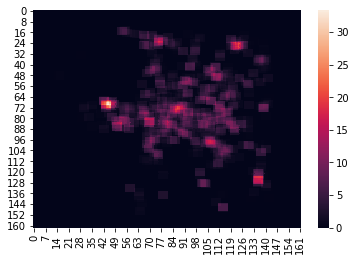

In [ ]:
sns.heatmap(density_rs) # heat map of resturants density

In [ ]:
np.where(density_position_rs[0] == MAX_Rho_rs) # find hightest density position of resturants

(array([70]), array([45]))

In [ ]:
# density heatmap of hotels
density_position_h  , MAX_Rho_h , MAX_position_h = local_density( data_all_objects['data_hotel'] , rating_depent = False ,  scan_shape = 'rectan' , ranging = 40  )
density_h = density_position_h[0]
position_h = density_position_h[1]

MAX_Rho = 152.77777777777777 , MAX_position = [120.19703654745831, 22.996729396442117]


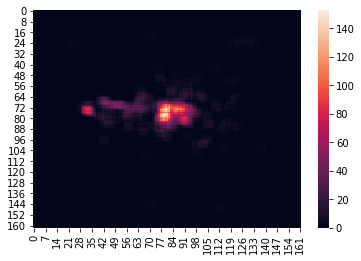

In [ ]:
sns.heatmap(density_h) # heat map of hotels density

In [ ]:
np.where(density_position_h[0] == MAX_Rho_h) # find hightest density position of hotels

(array([74]), array([80]))

In [ ]:
# density heatmap of convenience stores
density_position_cn  , MAX_Rho_cn , MAX_position_cn = local_density( data_all_objects['data_con']  , rating_depent = False ,  scan_shape = 'rectan' , ranging = 40 )
density_cn = density_position_cn[0]
position_cn = density_position_cn[1]

MAX_Rho = 25.0 , MAX_position = [120.22532467116754, 23.020207814357956]


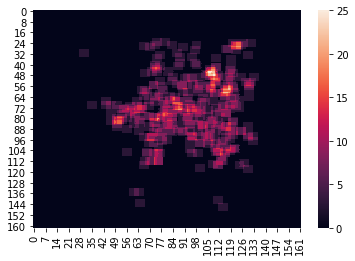

In [ ]:
sns.heatmap(density_cn) # heat map of convenience stores density

In [ ]:
np.where(density_position_cn[0] == MAX_Rho_cn) # find hightest density position of hotels

(array([46, 46, 48]), array([106, 107, 109]))

# Finding the top10 hightest density position "consider hotels distribution"


In [ ]:
# finding the top10 hightest density position "consider hotels distribution"
def search_peak(**kwargs):

  '''
  function : search peaks from density grid maps

  **kwargs : the density maps you want to consider , ex : (density_rs = density_rs , density_h = density_h .. )

  return : peaks with [ position_x(grid) ,position_y(grid) , density of resturant center , scors of center]

  '''

  # Importance : resturant > hotel > convenience store > beef soup > pork rice 


  # intial data of train_station 
  station_position = data_train_station[0]['location'] # r square inverse ?


  # initialize data of density
  peaks = []
  density_stack = np.array([ density for _ , density in kwargs.items() ])
  density_name = [ name.split('_')[1] for name in kwargs.keys() ]
  shape_W_L = density_stack.shape[1]

  for i in range(shape_W_L):
    for j in range(shape_W_L):

      surrounding = [ [k,l] for k in range(i-1,i+2) for l in range(j-1,j+2) if (k!=i or l!=j) and (shape_W_L>k>0 and shape_W_L>l>0) ] # find surranding 8 positions
      density_surrounding = [ density_stack[ : , pos_x , pos_y] for pos_x , pos_y in surrounding ]
      score_surroundig = [ reduce(lambda x,y: x+y, densitys) for densitys in density_surrounding ] # function.tools reduce method : https://www.itread01.com/content/1547813009.html
      

      # TODO : 把 socring 計算拆開成獨立函數 , 並在其中加入 weighting 計算式機制!!!


      density_center = density_stack[ : , i , j ]
      score_center = reduce(lambda x,y: x+y, density_center) # 這邊可針對不同類型store的重要度, 給不同的 wighting , ex: 沒 con 絕對不行 , 則評分就變 (hotel + rs)*con => con=0 ,score 直接變成 0    

      if len(list(filter(lambda x : x < score_center , score_surroundig) )) == 8 :
        peaks.append([ i , j , density_center[0], density_center[1] , density_center[2] , distance(grid_to_latlng[i][j],station_position)/1000 ,score_center/(distance(position_rs[i][j],station_position)/1000) ])
      else:

        continue

  return peaks

In [ ]:
peaks = search_peak(density_rs = density_rs ,density_h = density_h , density_cn = density_cn)

In [ ]:
peak_position = []

for peak in sorted(peaks , reverse=True , key = lambda x : x[6]):
  print(peak,grid_to_latlng[peak[0]][peak[1]])
  peak_position.append(grid_to_latlng[peak[0]][peak[1]])

[75, 96, 8.940972222222223, 52.77777777777778, 13.88888888888889, 0.14807264027489397, 510.6118101799548] [120.21264379  22.99582638]
[74, 93, 9.027777777777779, 80.55555555555556, 16.666666666666668, 0.30376768368655876, 349.7738755832683] [120.20971743  22.9967294 ]
[74, 86, 19.661458333333336, 119.44444444444444, 16.666666666666668, 1.0010945989490518, 155.60224738798343] [120.20288926  22.9967294 ]
[77, 91, 10.633680555555555, 72.22222222222223, 11.11111111111111, 0.6091750695991557, 154.25288817337895] [120.20776653  22.99402035]
[77, 89, 7.465277777777778, 88.88888888888889, 8.333333333333334, 0.7817097596881969, 133.92118839830914] [120.20581562  22.99402035]
[80, 91, 9.071180555555555, 91.66666666666667, 8.333333333333334, 0.8184973074001318, 133.25783673254634] [120.20776653  22.9913113 ]
[77, 98, 6.076388888888889, 27.77777777777778, 11.11111111111111, 0.4014706403068452, 112.00140997461406] [120.21459469  22.99402035]
[77, 81, 7.335069444444445, 141.66666666666669, 16.666666

In [ ]:
peak_position = np.array(peak_position)

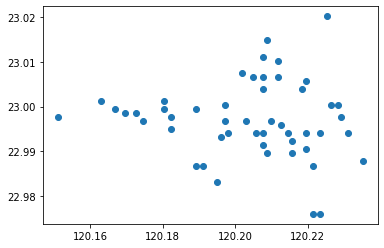

In [ ]:
# plot top peaks position consider hotels and convenience stores 
select_num = 50
plt.scatter(peak_position[:select_num,0],peak_position[:select_num,1])

In [ ]:
search_center = peak_position[0]
filter_f = partial(store_filter_by_criteria , center = search_center , criteria = 300 )
filtered_hotel = list(filter(filter_f , data_all_objects['data_hotel']))
#for name , posi , rat  in zip(name_h ,x_y_h , rating_h):
#  if posi in res and rat > 4.5:
#    print(name)

In [ ]:
for obj in filtered_hotel:
  if 'source_rating' in obj.__dict__.keys() and float(obj.source_rating) > 8.5:
    print(obj)

香格里拉台南遠東國際大飯店 Shangri-La's Far Eastern Plaza Hotel, Tainan is at [120.2142396, 22.9963445] and rating 4.4 in googlemap 
Journey Hostel 掘旅 is at [120.2147602, 22.9944656] and rating 4.5 in googlemap 
小城門住宅 is at [120.2155221, 22.9931224] and rating 4.7 in googlemap 
慢步南國 台南故事宿 is at [120.2148462, 22.9944608] and rating 4.6 in googlemap 
Old Man Captain HOSTEL is at [120.21263, 22.9966255] and rating 4.3 in googlemap 
鬍子趣旅 HUZI ROOM is at [120.210001, 22.993724] and rating 4.6 in googlemap 
沾米廚房 Jami Kitchen is at [120.2105863, 22.994999] and rating 4.1 in googlemap 
